In [1]:
import os
import copy

##### use library

In [3]:
from src.m01_refactored import get_path, plot_rho
from src.map_generators import * 
import numpy as np

In [5]:
d0 = 3
d1 = 8
t_max = 15

params = {
    'd0': d0,
    'd1': d1,
    't_max': t_max,
    'alpha': 0.1,
    'gamma': 1,
    'max_iterations': 100000
}

# get obstacles
obstacles_static = get_static_obstacles_v2(d0=3, d1=8)
obstacles_all = [copy.deepcopy(obstacles_static) for el in range(t_max+1)]

for t in range(t_max+1):
    obstacles_dynamic = get_dyn_obstacles_v2(t)
    obstacles_all[t].extend(obstacles_dynamic)

# get rewards 
reward_points = get_reward_points_v2(t_max)

result = get_path(params=params,
                  impenetrable_points=obstacles_all,
                  reward_points=reward_points)

tau = 14
tau = 13
tau = 12
tau = 11
tau = 10
tau = 9
tau = 8
tau = 7
tau = 6
tau = 5
tau = 4
tau = 3
tau = 2
tau = 1
tau = 0


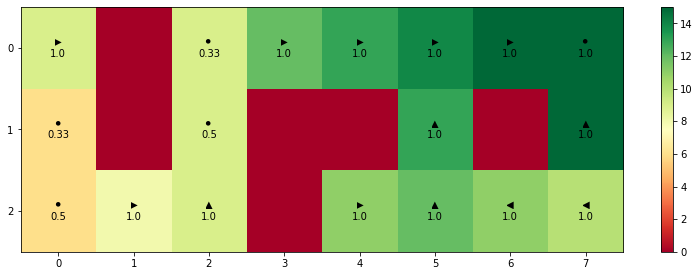

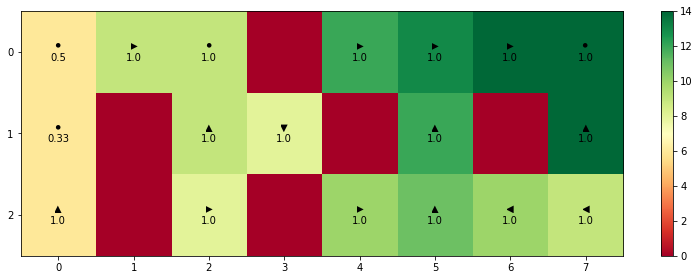

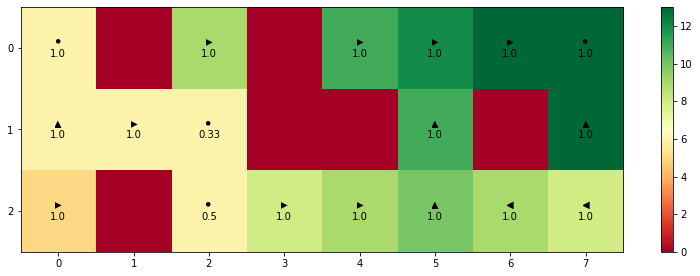

In [10]:
for t in range(3):
    fig = plot_rho(V=result['v_stars'][t], 
                 probabilities=result['rhos'][t], 
                 impenetrable_points=obstacles_all[t], 
                 d0=d0, 
                 d1=d1)

    fig.savefig(f'probs_{t}.png', transparent=True)

In [8]:
t=0
print(t)
print(np.round(result['rhos'][t][(1,2)], 3))
print(np.round(result['rhos'][t][(1,0)], 3))
print(np.round(result['rhos'][t][(2,0)], 3))
print(np.round(result['rhos'][t][(0,2)], 3))

t=1
print('\n\n', t)
print(np.round(result['rhos'][t][(0,0)], 3))
print(np.round(result['rhos'][t][(1,0)], 3))


t=2
print('\n\n', t)
print(np.round(result['rhos'][t][(1,2)], 3))
print(np.round(result['rhos'][t][(2,2)], 3))

0
[0.5 0.5 0.  0.  0. ]
[0.333 0.333 0.333 0.    0.   ]
[0.5 0.5 0.  0.  0. ]
[0.333 0.    0.333 0.    0.333]


 1
[0.5 0.  0.5 0.  0. ]
[0.333 0.333 0.    0.333 0.   ]


 2
[0.333 0.333 0.333 0.    0.   ]
[0.5 0.5 0.  0.  0. ]


##### trajectory explorer

In [8]:
def traj_realization(rhos, t_max, x_init=(2,0), x_final=(0,7)):

    n_steps = 0
    t = 0
    x, x_new = x_init, None
    steps=[x]

    while x_new != x_final and t < t_max:

        move_prob = rhos[t][x]
        move_cumulative_prob = np.cumsum(move_prob)

        rv = np.random.rand()
        mask = rv < move_cumulative_prob
        action = np.argmax(mask)

        if action == 0:
            x_new = x
        elif action == 1:
            x_new = (x[0]-1, x[1])
        elif action == 2:
            x_new = (x[0]+1, x[1])
        elif action == 3:
            x_new = (x[0], x[1]+1)
        else:
            x_new = (x[0], x[1]-1)

        x = x_new
        t += 1
        n_steps += 1
        steps.append(x)

    return n_steps, steps

In [9]:
rhos = result['rhos']

In [10]:
n_steps_collection = [traj_realization(rhos, t_max, x_init=(2,0), x_final=(0,7)) for _ in range(100000)]
n_steps_collection = map(lambda x: x[0], n_steps_collection)
n_steps_collection = list(n_steps_collection)
set(n_steps_collection)

{10}

In [11]:
n_steps_collection = [traj_realization(rhos, t_max, x_init=(2,0), x_final=(0,7)) for _ in range(10000)]
n_steps_collection = map(lambda x: str(x[1]), n_steps_collection)
n_steps_collection = list(n_steps_collection)

unique, counts = np.unique(n_steps_collection, return_counts=True)
print(np.asarray((unique, counts)).T)

[['[(2, 0), (1, 0), (0, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '1626']
 ['[(2, 0), (1, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '1699']
 ['[(2, 0), (1, 0), (1, 1), (1, 2), (0, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '813']
 ['[(2, 0), (1, 0), (1, 1), (1, 2), (1, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '846']
 ['[(2, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'
  '5016']]


In [109]:
unique

array(['[(2, 0), (1, 0), (0, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]',
       '[(2, 0), (1, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]',
       '[(2, 0), (1, 0), (1, 1), (1, 2), (0, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]',
       '[(2, 0), (1, 0), (1, 1), (1, 2), (1, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]',
       '[(2, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]'],
      dtype='<U88')